In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import math

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# user defined.
from helpful_functions import MLFunctions
from plot_setup import *

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'])

In [3]:
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")
sales['date'] = sales['date'].dt.to_period('D')

In [ ]:
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()

In [ ]:
sales['time'] = arr

In [ ]:
sales.head(20)

In [10]:
sales = (sales
         .groupby(['date', 'shop_id', 'item_id'])
         .sum())

In [12]:
sales.tail()

item_price  item_cnt_day     time
date       shop_id item_id                                   
2015-10-31 59      20730         499.0           1.0  2899165
                   20866         699.0           1.0  2899147
                   20949           5.0           1.0  2899162
                   21369         169.0           1.0  2899141
                   21449         449.0           1.0  2899127

In [17]:
sales.head()

item_price  item_cnt_day  time
date       shop_id item_id                                
2013-01-01 2       991            99.0           1.0     0
                   1472         2599.0           1.0     1
                   1905          249.0           1.0     2
                   2920          599.0           2.0     3
                   3320         1999.0           1.0     4

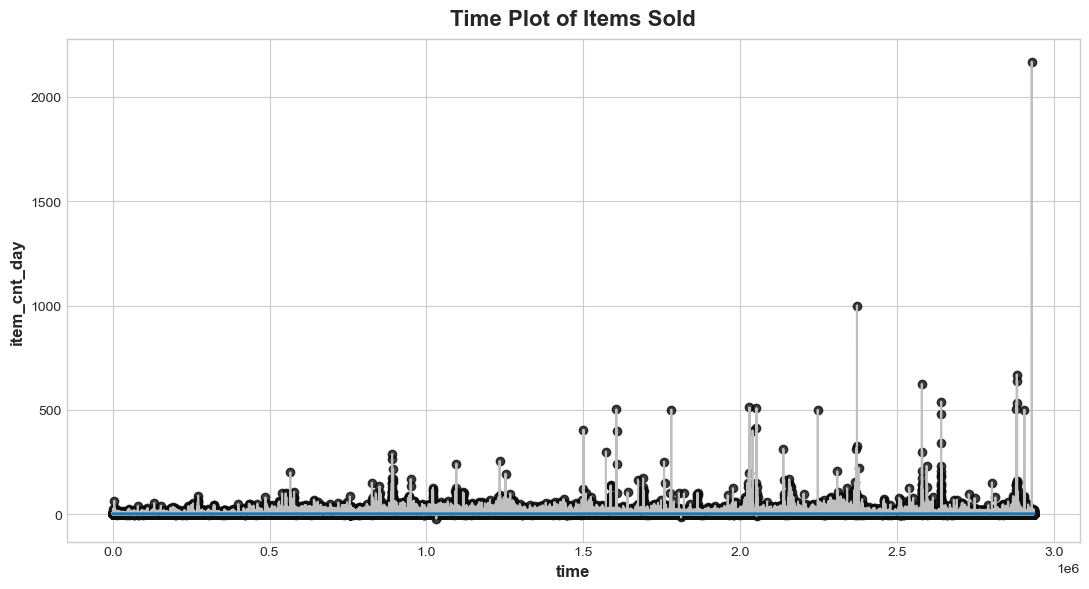

In [19]:
fig, ax = plt.subplots()
ax.plot('time', 'item_cnt_day', data=sales, color='0.75')
ax = sns.regplot(x='time', y='item_cnt_day', data=sales, ci=None, scatter_kws=dict(color='0.05'))
ax.set_title('Time Plot of Items Sold');

In [15]:
sales['lag_1'] = sales['item_cnt_day'].shift(1)
sales['lag_2'] = sales['item_cnt_day'].shift(2)
sales['lag_3'] = sales['item_cnt_day'].shift(3)
sales['lag_5'] = sales['item_cnt_day'].shift(5)
sales['lag_6'] = sales['item_cnt_day'].shift(6)
sales['lag_7'] = sales['item_cnt_day'].shift(7)
sales['lag_8'] = sales['item_cnt_day'].shift(8)

In [17]:
sales.head()

,item_cnt_day,time,lag_1,lag_2,lag_3,lag_5,lag_6,lag_7,lag_8
date,,,,,,,,,
2013-01-01,1951.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,8198.0,1,1951.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,7422.0,2,8198.0,1951.0,NaN,NaN,NaN,NaN,NaN
2013-01-04,6617.0,3,7422.0,8198.0,1951.0,NaN,NaN,NaN,NaN
2013-01-05,6346.0,4,6617.0,7422.0,8198.0,NaN,NaN,NaN,NaN


In [64]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(sales.item_cnt_day, lags=4)
X = X.fillna(0.0)

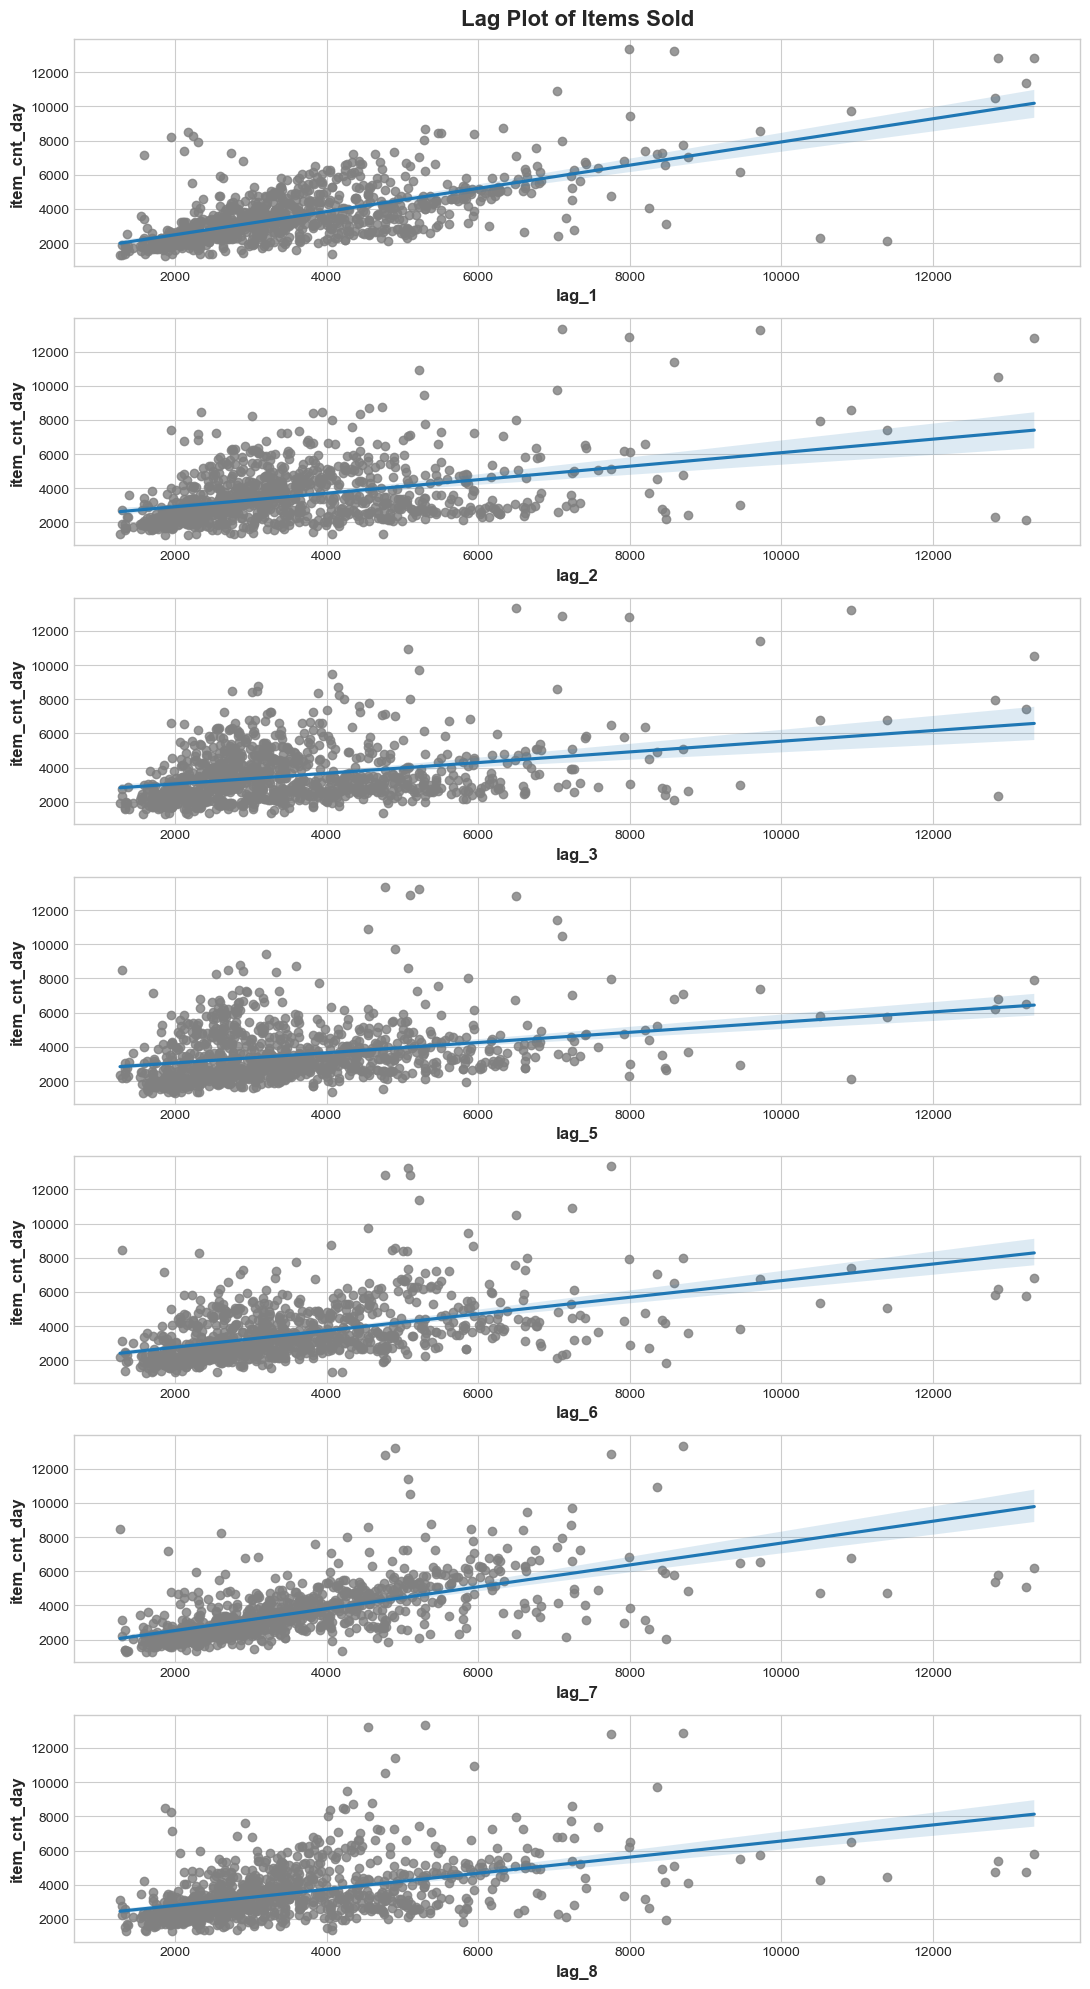

In [19]:
fig, (ax1,ax2,ax3,ax5,ax6,ax7,ax8) = plt.subplots(7,1, figsize=(11,20))
_ = sns.regplot(x='lag_1', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax1)
_ = sns.regplot(x='lag_2', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax2)
_ = sns.regplot(x='lag_3', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax3)
_ = sns.regplot(x='lag_5', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax5)
_ = sns.regplot(x='lag_6', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax6)
_ = sns.regplot(x='lag_7', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax7)
_ = sns.regplot(x='lag_8', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'), ax=ax8)
ax1.set_title('Lag Plot of Items Sold');

In [21]:
items_sold = sales.loc[:, ['item_cnt_day']]
trend = items_sold.rolling(window=90,
                           center=True,
                           min_periods=45).mean()

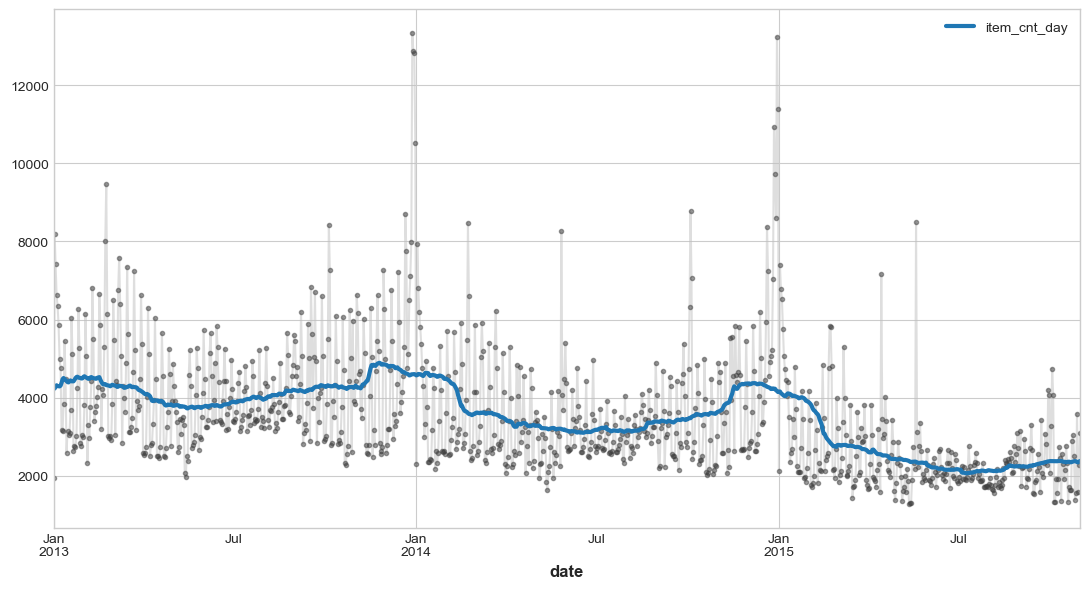

In [23]:
# Make a plot
ax = items_sold.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [25]:
# below code shows how fourier features are generated
'''
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
fourier = fourier_features(sales.index, freq=365.25, order=4)
'''

'\ndef fourier_features(index, freq, order):\n    time = np.arange(len(index), dtype=np.float32)\n    k = 2 * np.pi * (1 / freq) * time\n    features = {}\n    for i in range(1, order + 1):\n        features.update({\n            f"sin_{freq}_{i}": np.sin(i * k),\n            f"cos_{freq}_{i}": np.cos(i * k),\n        })\n    return pd.DataFrame(features, index=index)\nfourier = fourier_features(sales.index, freq=365.25, order=4)\n'

In [27]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

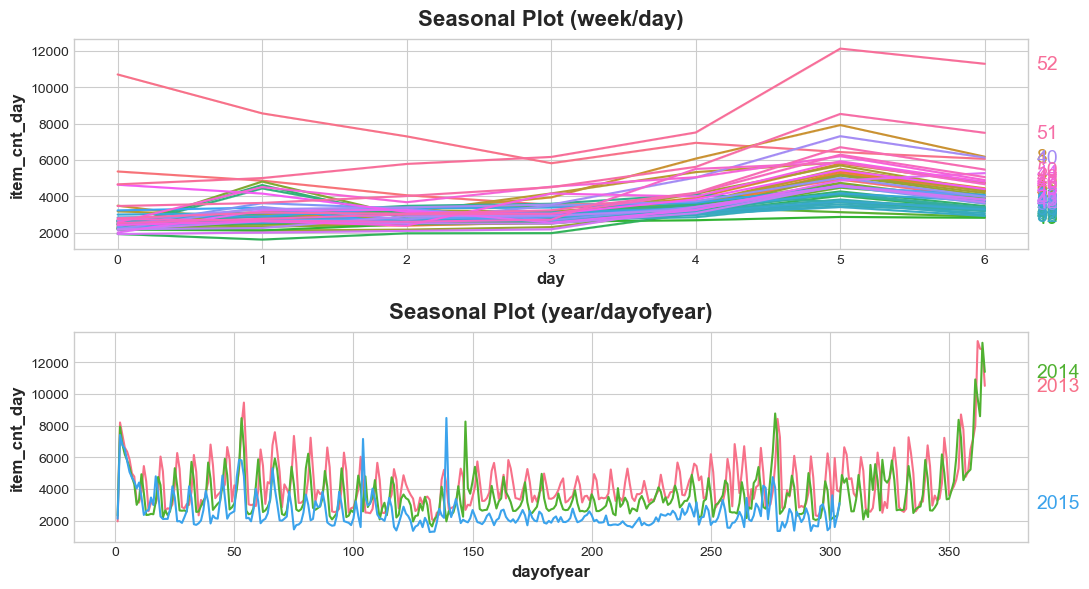

In [29]:
X = sales.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="item_cnt_day", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="item_cnt_day", period="year", freq="dayofyear", ax=ax1);

In [30]:
X.head()

,item_cnt_day,time,lag_1,lag_2,lag_3,lag_5,lag_6,lag_7,lag_8,day,week,dayofyear,year
date,,,,,,,,,,,,,
2013-01-01,1951.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,2013
2013-01-02,8198.0,1,1951.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,2013
2013-01-03,7422.0,2,8198.0,1951.0,NaN,NaN,NaN,NaN,NaN,3,1,3,2013
2013-01-04,6617.0,3,7422.0,8198.0,1951.0,NaN,NaN,NaN,NaN,4,1,4,2013
2013-01-05,6346.0,4,6617.0,7422.0,8198.0,NaN,NaN,NaN,NaN,5,1,5,2013


In [31]:
X.tail()

,item_cnt_day,time,lag_1,lag_2,lag_3,lag_5,lag_6,lag_7,lag_8,day,week,dayofyear,year
date,,,,,,,,,,,,,
2015-10-27,1551.0,1029,1387.0,2495.0,3035.0,1632.0,1647.0,1711.0,1341.0,1,44,300,2015
2015-10-28,3593.0,1030,1551.0,1387.0,2495.0,2901.0,1632.0,1647.0,1711.0,2,44,301,2015
2015-10-29,1589.0,1031,3593.0,1551.0,1387.0,3035.0,2901.0,1632.0,1647.0,3,44,302,2015
2015-10-30,2274.0,1032,1589.0,3593.0,1551.0,2495.0,3035.0,2901.0,1632.0,4,44,303,2015
2015-10-31,3104.0,1033,2274.0,1589.0,3593.0,1387.0,2495.0,3035.0,2901.0,5,44,304,2015


In [32]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

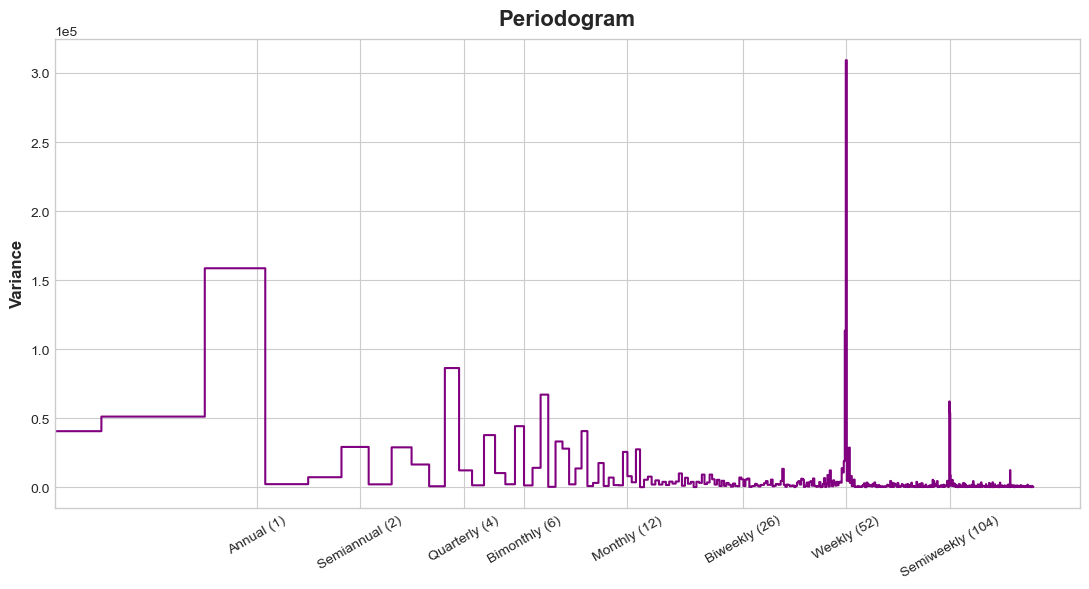

In [33]:
plot_periodogram(sales.item_cnt_day)

In [34]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [35]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

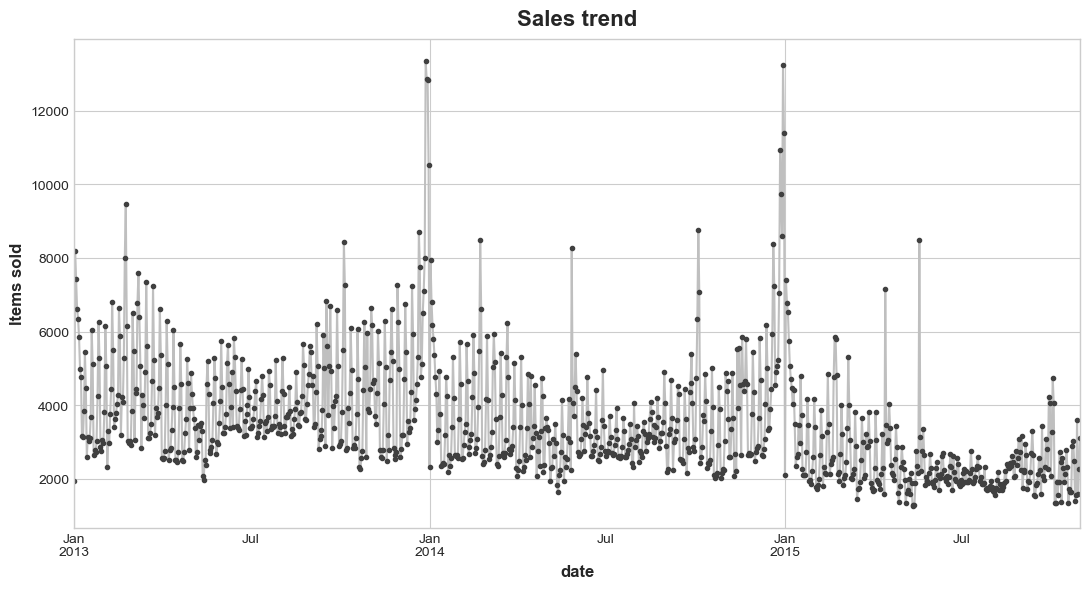

In [36]:
ax = sales.item_cnt_day.plot(title="Sales trend", **plot_params)
_ = ax.set(ylabel="Items sold")

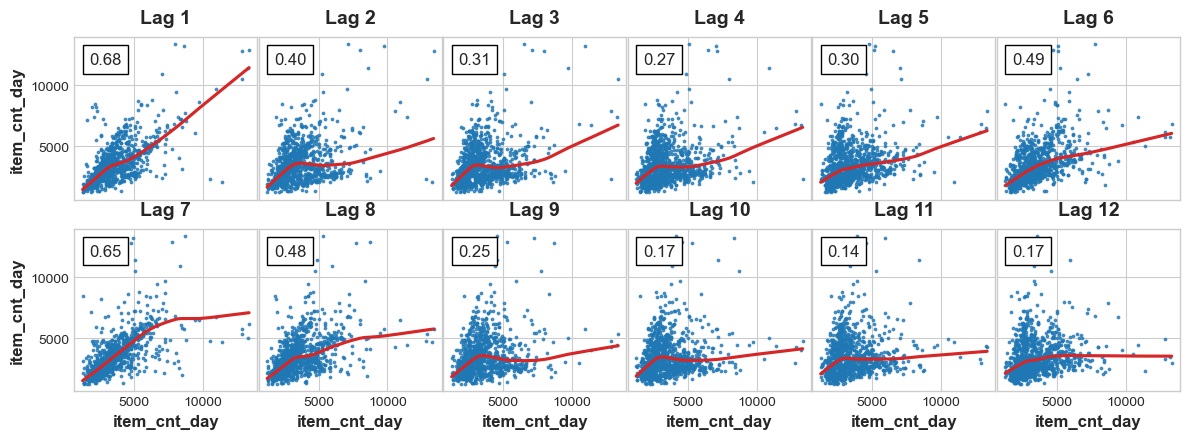

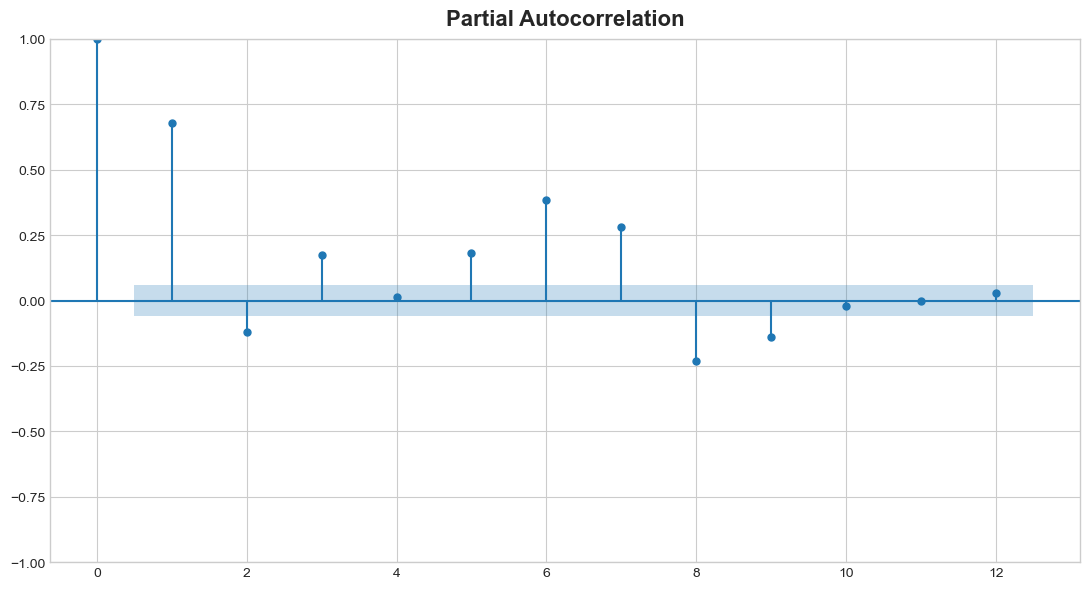

In [37]:
_ = plot_lags(sales.item_cnt_day, lags=12, nrows=2)
_ = plot_pacf(sales.item_cnt_day, lags=12)